# install necessary packages

In [1]:
%%capture

!pip install pytube
!pip install imutils
!pip install img2pdf
!pip install piqa
!pip install img2pdf

!pip install paddleocr==2.5.0.3
cpu = False
if(cpu):
    !pip install paddlepaddle==2.3.0
else:
    #!pip install paddlepaddle-gpu==2.3.0
    !python -m pip install paddlepaddle-gpu==2.3.0.post111 -f https://www.paddlepaddle.org.cn/whl/linux/mkl/avx/stable.html
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Cool Imports

In [2]:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import time
import cv2
import imutils
import shutil
import img2pdf
import glob

from IPython.display import Video,Image

import math
import os

import pytube
from pytube import YouTube 

import zipfile
    

import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity

import torch

from shapely.geometry import Polygon

from torchvision import transforms
from piqa import SSIM


# 1. Import paddleocr class from paddleocr
from paddleocr import PaddleOCR
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path   
from PIL import Image as im
import os
import copy
import img2pdf

plt.figure(figsize = (1000,1000))
# Add this command to display a notebook drawing using matplotlib.pyplot
%matplotlib inline

In [3]:
print(pytube.__version__)
print(cv2.__version__)
print(img2pdf.__version__)
print(imutils.__version__)
print(img2pdf.__version__)

12.1.0
4.4.0
0.4.4
0.5.4
0.4.4


# Motivation

the main idea of this approach was to  find unique slides from presentation videos using the dbresnet text detection models detection output result on consecutive image pairs (it gives us information about similar text between image pairs and this feature can indicate the image pair are near duplicate or not.if duplicate then, one of them needs to be removed. but few difficulties were observed :

1. slide can contain various animation and in that case positional information are lost
2. launching dbnet on many images (frame images) is time consuming

to tackle these issues we combine both SSIM and dbresnet50 for efficient 3 step filtering. SSIM first reduces many frames and it is faster,then on reduced frames we apply dbresnet50 and ensemble of SSIM and dbresnet50 for efficient filtering


# summary / contributions

this notebook demonstrates how to convert multilingual presentation videos into readable pdf file. the solution is developed by combining structural similarity index measure (SSIM) with [Real-Time Scene Text Detection with Differentiable Binarization and Adaptive Scale Fusion](https://arxiv.org/abs/2202.10304) of [paddleocr](https://github.com/PaddlePaddle/PaddleOCR)

we compute both ssim and dbnet using gpu,so the code is enough fast.



**Rough Pseudo Code :**

step 1 -> gather youtube video

step 2 -> extract distinct unique frames from videos

step 3 -> filter 1 : apply ssim on consecutive frame pairs with high confident on step 2 dataset to reduce redundant frames (use ssim on gpu)

step 4 -> filter 2 : select least frames by eliminating duplicate (use high IOU hit count between  image pairs for more filtering on filter 1 dataset)

step 5 -> filter 3(high detection overlap count followed by high ssim checking) : on filter 2 data, we again count matched bboxes between image pair(using dbresnet50) and check if we have high bbox detection coverage or not,if yes,then we eliminate first image from image pair as we have detected near duplicate again

**NOTE ->  the solution is multilingual,hence it should work on english,bangla,hindi etc presentation videos**

# Gather YouTube Videos

In [4]:
#from https://pythonsansar.com/download-youtube-videos-using-python-pytube/

yt_video_links = [
    'https://www.youtube.com/watch?v=15lVDRDkJGE&t=2s',
    'https://www.youtube.com/watch?v=N3CMTEbPTsE&t=372s',
    'https://www.youtube.com/watch?v=jjkwyKkqa9M',
    'https://www.youtube.com/watch?v=Ybhi6MJL57M',
    'https://www.youtube.com/watch?v=CIolRxDxYvc',
    'https://www.youtube.com/watch?v=k6lCD0iVExo'
]

yt = YouTube(yt_video_links[5])

print("\n\ntitle ->\n",yt.title)
print("\n\nviews ->\n",yt.views)
print("\n\n\n\nlength ->\n",yt.length)
print("\n\nauthor ->\n",yt.author)
print("\n\n\n\ndescription ->\n",yt.description)
print("\n\n\n\nrating ->\n",yt.rating)
print("\n\nthumbnail_url ->\n",yt.thumbnail_url)
print("\n\npublish_date ->\n",yt.publish_date)
print("\n\nstreams ->\n",yt.streams)
print("\n\nProgressive streaming ->\n",yt.streams.filter(progressive=True).get_highest_resolution())


# this method will download the highest resolution that video is available
yt_video = yt.streams.get_highest_resolution()
filename = yt_video.download()
print("filename -> ",filename)



title ->
 Sesamoid bone. Prof. Dr. Md. Ashfaqur Rahman


views ->
 812




length ->
 320


author ->
 We like Anatomy




description ->
 In Bangla




rating ->
 None


thumbnail_url ->
 https://i.ytimg.com/vi/k6lCD0iVExo/sddefault.jpg


publish_date ->
 2021-07-11 00:00:00


streams ->
 [<Stream: itag="17" mime_type="video/3gpp" res="144p" fps="6fps" vcodec="mp4v.20.3" acodec="mp4a.40.2" progressive="True" type="video">, <Stream: itag="18" mime_type="video/mp4" res="360p" fps="25fps" vcodec="avc1.42001E" acodec="mp4a.40.2" progressive="True" type="video">, <Stream: itag="22" mime_type="video/mp4" res="720p" fps="25fps" vcodec="avc1.64001F" acodec="mp4a.40.2" progressive="True" type="video">, <Stream: itag="137" mime_type="video/mp4" res="1080p" fps="25fps" vcodec="avc1.640028" progressive="False" type="video">, <Stream: itag="136" mime_type="video/mp4" res="720p" fps="25fps" vcodec="avc1.64001f" progressive="False" type="video">, <Stream: itag="135" mime_type="video/mp4" res="480p

# Controllable Parameters


In [5]:
#choosing dynamic fps based on video length for making computation fast without sacrificing vital informations
if(yt.length>=1800):
    fps = 0.5
elif(yt.length<1800 and yt.length>1200):
    fps = 0.75
else:
    fps = 1.0
    
class Hparams():
    def __init__(self):
        self.title = yt.title
        self.embed_video = False
        self.rmdir = False
        self.frames_per_second = fps
        self.ssim_threshold = 0.98
        self.visualize_img_pairs = True
        self.iou_threshold = 0.9
        self.min_match_thr = 2
        self.conf_thr = 0.8
        self.withoutfinal_filter = True
        self.is_ssim = False
 
    
hp = Hparams()
print(hp.frames_per_second)

1.0


In [6]:
if(hp.embed_video):
    Video(filename,embed=True)

# Extracting-distinct-unique-frames-from-videos

In [7]:
#https://stackoverflow.com/questions/54045766/python-extracting-distinct-unique-frames-from-videos

def video_to_images(video_path, frames_per_second=1):
    cam = cv2.VideoCapture(video_path)
    frame_list = []
    frame_rate = cam.get(cv2.CAP_PROP_FPS) #video frame rate



    # frame
    current_frame = 0
    
    # create directory if it does not exist
    images_path = f'./images' 
    if not os.path.exists(images_path):
        os.makedirs(images_path)

    if frames_per_second > frame_rate or frames_per_second == -1:
        frames_per_second = frame_rate
    
    while(True):
        
        # reading from frame
        ret,frame = cam.read()
        
        if ret:
             
            # if video is still left continue creating images
            file_name = f'{images_path}/frame' + str(current_frame) + '.jpg'
            #print ('Creating...' + file_name)
            # print('frame rate', frame_rate)


            #print(current_frame,frame_rate,frames_per_second)
            if current_frame % (math.floor(frame_rate/frames_per_second)) == 0:

                # adding frame to list
                frame_list.append(frame)
#                 print(current_frame,file_name,frame)
                # writing selected frames to images_path
                cv2.imwrite(file_name, frame)
    
    
            # increasing counter so that it will
            # show how many frames are created
            current_frame += 1
        else:
            break
    
    # Release all space and windows once done
    cam.release()
#     cv2.destroyAllWindows()

    return frame_list

# collecting least frames,required for finding unique slides

In [8]:
%%time

frames = video_to_images(filename, frames_per_second=hp.frames_per_second)
len(frames)

CPU times: user 30.8 s, sys: 933 ms, total: 31.7 s
Wall time: 21.2 s


320

# Converting saved images directory into zip directory so that we can remove the folder later

In [9]:

def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file), 
                       os.path.relpath(os.path.join(root, file), 
                                       os.path.join(path, '..')))

with zipfile.ZipFile('images.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipdir('./images/', zipf)

In [10]:
images = os.listdir('./images')
images.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
images[:20]

['frame0.jpg',
 'frame25.jpg',
 'frame50.jpg',
 'frame75.jpg',
 'frame100.jpg',
 'frame125.jpg',
 'frame150.jpg',
 'frame175.jpg',
 'frame200.jpg',
 'frame225.jpg',
 'frame250.jpg',
 'frame275.jpg',
 'frame300.jpg',
 'frame325.jpg',
 'frame350.jpg',
 'frame375.jpg',
 'frame400.jpg',
 'frame425.jpg',
 'frame450.jpg',
 'frame475.jpg']

# structural similarity index measure (SSIM) calculation using GPU

if the consecutive image pair gets ssim score above hp.ssim_threshold then we consider first image from the pair as it's duplicate or say near duplicate then we increment i,j for next comparison to filter redundant samples using high ssim threshold like -> score < hp.ssim_threshold

using this approach we are reducing duplicate frames first, the code cell below is fast enough as it computes SSIM on gpu,,,in cpu ssim took longer to finish calculation. this step helps us reduce unwanted samples faster so later dbnet gets less sample to deal with **(it helps reduce overall time to convert videos into readable pdf slides)**

In [11]:
%%time

transform = transforms.ToTensor()
ssim = SSIM().cuda()
images_path = f'./filtered' 
if not os.path.exists(images_path):
    os.makedirs(images_path)
    
def calculate_ssim(image,image1,write_img = True):
    x = transform(image).unsqueeze(0).cuda() # .cuda() for GPU
    y = transform(image1).unsqueeze(0).cuda()

    
    score = ssim(x, y).data.tolist()

    if(score > hp.ssim_threshold):
        return score
    if(write_img):
        cv2.imwrite(f'./{images_path}/{images[idx]}',image)
    return score
        
for idx in range(len(images) - 1):
    image = cv2.imread(f'./images/{images[idx]}')
    image1 = cv2.imread(f'./images/{images[idx+1]}')
    score = calculate_ssim(image,image1)

CPU times: user 15.6 s, sys: 1.22 s, total: 16.8 s
Wall time: 17.8 s


In [12]:
images = os.listdir('./filtered')
images.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
print(images[:10],len(images))

with zipfile.ZipFile('filtered.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipdir('./filtered/', zipf)

    

['frame25.jpg', 'frame100.jpg', 'frame125.jpg', 'frame250.jpg', 'frame275.jpg', 'frame300.jpg', 'frame325.jpg', 'frame350.jpg', 'frame375.jpg', 'frame400.jpg'] 64


# frame pair visualization

download https://paddleocr.bj.bcebos.com/PP-OCRv3/multilingual/Multilingual_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/ml/Multilingual_PP-OCRv3_det_infer/Multilingual_PP-OCRv3_det_infer.tar


100%|██████████| 3.85M/3.85M [00:11<00:00, 341kiB/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv3/multilingual/arabic_PP-OCRv3_rec_infer.tar to /root/.paddleocr/whl/rec/arabic/arabic_PP-OCRv3_rec_infer/arabic_PP-OCRv3_rec_infer.tar


100%|██████████| 9.98M/9.98M [00:22<00:00, 453kiB/s] 


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 1.45M/1.45M [00:08<00:00, 168kiB/s]

[2022/08/10 08:44:22] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_fce_box_type='poly', det_limit_side_len=960, det_limit_type='max', det_model_dir='/root/.paddleocr/whl/det/ml/Multilingual_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_box_type='quad', det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgn

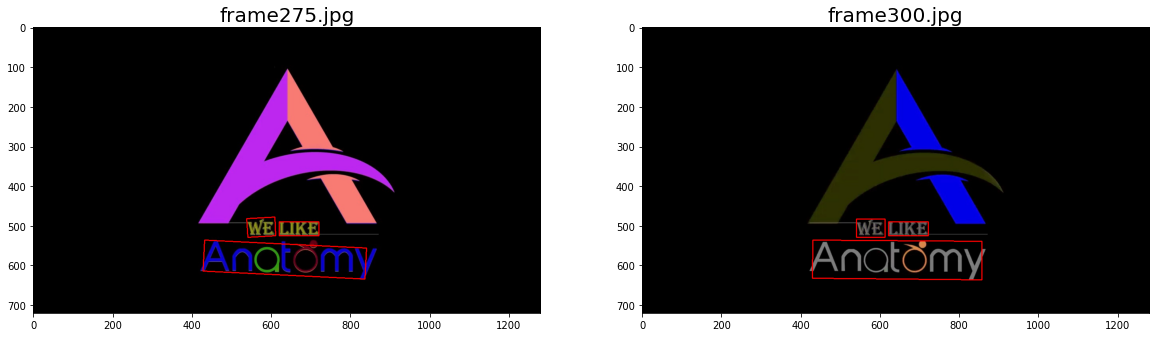

Image similarity 0.9370919646530979


In [13]:


#https://gist.github.com/mstankie/71e49f628beac320953e0460b8ee78c2
# 2. Declare PaddleOCR class
ocr = PaddleOCR(use_angle_cls=True, lang='ar',use_gpu = True)  

def viz_img_pair(images,i,j):
    image = cv2.imread(f'./filtered/{images[i]}')
    image1 = cv2.imread(f'./filtered/{images[j]}')
    
    result = ocr.ocr(image, rec=False)
    boxes = [line[0] for line in result]
    for box in result:
        box = np.reshape(np.array(box), [-1,1,2]).astype(np.int64)
        image = cv2.polylines(np.array(image), [box], True, (255,0,0), 2)

    f = plt.figure(figsize=(20,20))
    f.add_subplot(1,2, 1)
    plt.title(f'{images[i]}', fontdict={'fontsize':20})
    plt.imshow(image)
    
    result = ocr.ocr(image1, rec=False)
    boxes = [line[0] for line in result]
    for box in result:
        box = np.reshape(np.array(box), [-1,1,2]).astype(np.int64)
        image1 = cv2.polylines(np.array(image1), [box], True, (255,0,0), 2)

    f.add_subplot(1,2, 2)
    plt.title(f'{images[i+1]}', fontdict={'fontsize':20})
    plt.imshow(image1)
    plt.show(block=True)

    # Convert images to grayscale
    before_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    after_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)

    # Compute SSIM between two images
    (score, diff) = structural_similarity(before_gray, after_gray, full=True)
    print("Image similarity", score)
    
if(hp.visualize_img_pairs):
    viz_img_pair(images=images,i=4,j=5)

# Sort bboxes detected by  db_resnet50 text detection algorithm of paddleocr

In [14]:
# https://github.com/vigneshgig/sorting_algorthim_for_bounding_box_from_left_to_right_and_top_to_bottom

def sorted_boxes(dt_boxes):
    """
    Sort text boxes in order from top to bottom, left to right
    args:
        dt_boxes(array):detected text boxes with shape [4, 2]
    return:
        sorted boxes(array) with shape [4, 2]
    """
    num_boxes = dt_boxes.shape[0]
    sorted_boxes = sorted(dt_boxes, key=lambda x: (x[0][1], x[0][0]))
    _boxes = list(sorted_boxes)

    for i in range(num_boxes - 1):
        if abs(_boxes[i + 1][0][1] - _boxes[i][0][1]) < 100 and (_boxes[i + 1][0][0] < _boxes[i][0][0]):
            tmp = _boxes[i]
            _boxes[i] = _boxes[i + 1]
            _boxes[i + 1] = tmp
    return _boxes


# Detect all unique and informative images and save them in folder name unique

on consecutive frame pair,we first detect and sort text bboxes and apply iou on top of them, we compute and count_matched_bboxes iou with high threshold and check if image pair has got IOU count greater or equal to the previous pair or not,if yes, we save and update the i'th image/frame otherwise we move on to next i,j image pair comparison.

this way we try to eliminate more redundant frames

In [15]:
images_path = f'./unique' 
if not os.path.exists(images_path):
    os.makedirs(images_path)
    

def calculate_iou(box_1, box_2):
    poly_1 = Polygon(box_1)
    poly_2 = Polygon(box_2)
    iou = poly_1.intersection(poly_2).area / poly_1.union(poly_2).area
    return iou

def count_matched_bboxes(img,img1,detector):
    
    dt_boxes,_= detector.text_detector(img) 
    dt_boxes=sorted_boxes(dt_boxes)
    
    dt_boxes1,_= detector.text_detector(img1) 
    dt_boxes1=sorted_boxes(dt_boxes1)

    minimum = min(len(dt_boxes), len(dt_boxes1))
    
    if(len(dt_boxes)<1):
        # we don't care if there is no text
        return 0,minimum
    
    if(len(dt_boxes1)<1):
        # we don't care if there is no text
        return 0,minimum
    #         diff = abs(len(dt_boxes)-len(dt_boxes1))

    count = 0
    if(len(dt_boxes)>len(dt_boxes1)):
        for box_n in range(len(dt_boxes1)):
            for box_num in range(len(dt_boxes)):
                iou = calculate_iou(dt_boxes[box_num], dt_boxes1[box_n])
                if(iou > hp.iou_threshold):
                    count+=1
    else:
        for box_num in range(len(dt_boxes)):
            for box_n in range(len(dt_boxes1)):
                iou = calculate_iou(dt_boxes[box_num], dt_boxes1[box_n])
                if(iou > hp.iou_threshold):
                    count+=1
    
    return count,minimum



def save_unique_images(detector,folder):
    '''
    detect all unique and informative images and save them
    images using db_resnet50 text detection algorithm of paddleocr
    args :
        detector : text detection algorithm (default db_resnet50 of paddle)
        folder   : folder loc containing all images
    '''
    
    files = os.listdir(folder)
    files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    for i in range(len(files)-1):
        prev = 1
        for j in range(i+1, len(files)):
            img_path=f"{folder}/{files[i]}"
            img=cv2.imread(img_path)

            img_path=f"{folder}/{files[j]}"
            img1=cv2.imread(img_path)

            try:
                img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                img1=cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
            except:
                print("failed during COLOR_BGR2RGB image...")
           
            count,_ = count_matched_bboxes(img,img1,detector)
            if(count>= prev):
                prev = count
                cv2.imwrite(f'./{images_path}/{files[i]}',img1)
            else:    
                break

#             maximum = max(len(dt_boxes), len(dt_boxes1))
#             if(count>= maximum * 0.6):
#                 cv2.imwrite(f'./{images_path}/{files[j]}',img1)
#             break

        
    

# Find and reduce redundant frames

In [16]:
%%time


folder = './filtered'

save_unique_images(detector = ocr,folder=folder)

CPU times: user 26.3 s, sys: 659 ms, total: 27 s
Wall time: 25.2 s


In [17]:
print(len(os.listdir('./unique')))
os.listdir('./unique')

49


['frame6525.jpg',
 'frame1300.jpg',
 'frame4725.jpg',
 'frame2600.jpg',
 'frame2400.jpg',
 'frame3825.jpg',
 'frame7900.jpg',
 'frame250.jpg',
 'frame1975.jpg',
 'frame5800.jpg',
 'frame3425.jpg',
 'frame4750.jpg',
 'frame7075.jpg',
 'frame7150.jpg',
 'frame1825.jpg',
 'frame7100.jpg',
 'frame275.jpg',
 'frame7925.jpg',
 'frame1475.jpg',
 'frame1675.jpg',
 'frame2375.jpg',
 'frame3750.jpg',
 'frame1850.jpg',
 'frame5000.jpg',
 'frame1700.jpg',
 'frame7425.jpg',
 'frame6125.jpg',
 'frame2425.jpg',
 'frame7800.jpg',
 'frame7650.jpg',
 'frame6050.jpg',
 'frame1075.jpg',
 'frame7825.jpg',
 'frame2800.jpg',
 'frame3400.jpg',
 'frame7875.jpg',
 'frame1800.jpg',
 'frame7675.jpg',
 'frame7725.jpg',
 'frame300.jpg',
 'frame325.jpg',
 'frame5525.jpg',
 'frame7750.jpg',
 'frame4100.jpg',
 'frame3025.jpg',
 'frame7850.jpg',
 'frame5500.jpg',
 'frame6025.jpg',
 'frame7700.jpg']

# save unique Frames to pdf

In [18]:

def unique_frames_to_pdf(output_folder_screenshot_path,without_final_filter = False):
    if(without_final_filter):
        output_pdf_path = f'./w.o.f_{hp.title}.pdf'
    else:
        output_pdf_path = f'./{hp.title}.pdf'
    print('output_folder_screenshot_path', output_folder_screenshot_path)
    print('output_pdf_path', output_pdf_path)
    print('converting images to pdf..')
    images = os.listdir(output_folder_screenshot_path)
    images.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    for i in range(len(images)):
        images[i] = f"{output_folder_screenshot_path}/{images[i]}"

    with open(output_pdf_path, "wb") as f:
        f.write(img2pdf.convert(images))
    print('Pdf Created!')
    print('pdf saved at', output_pdf_path)
    
if(hp.withoutfinal_filter):
    unique_frames_to_pdf('./unique', True)

output_folder_screenshot_path ./unique
output_pdf_path ./w.o.f_Sesamoid bone. Prof. Dr. Md. Ashfaqur Rahman.pdf
converting images to pdf..
Pdf Created!
pdf saved at ./w.o.f_Sesamoid bone. Prof. Dr. Md. Ashfaqur Rahman.pdf


# final filtering

at this point,it's possible that there still can exist few more redundant samples,they don't always look like redundant because of complex animation or other stuffs but according to their other key features like "mid to near high bbox overlap coverage", they are redundant,we try to do one last filtering to detect and eliminate those redundant samples


again,
with high threshold we check the ssim score of current image pair and check if they are similar or not,if yes,we delete first one of them,if no then  we do next step validation,we pass the frame pair to dbresnet50 and count the matched bboxes of these consecutive frames. if count>= minimum * hp.conf_thr  that means the we have high bbox detection overlaps which indicates that slides are most likely to contain similar informations,hence we eliminate the first one from the consecutive pair and use the 2nd one for next i,j comparison before making decision that "it's unique".

In [19]:
%%time

images = os.listdir('./unique')
images.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

for idx in range(len(images) - 1):
    
    image = cv2.imread(f'./unique/{images[idx]}')
    image1 = cv2.imread(f'./unique/{images[idx+1]}')
    if(hp.is_ssim):
        score = calculate_ssim(image,image1,write_img = False)
        if(score>hp.ssim_threshold):
            os.remove(f'./unique/{images[idx]}')
            continue

    try:
        img=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        img1=cv2.cvtColor(image1,cv2.COLOR_BGR2RGB)
    except:
        print("failed during COLOR_BGR2RGB image...")

    count,minimum = count_matched_bboxes(img,img1,ocr)

    if(count>= minimum * hp.conf_thr):
        os.remove(f'./unique/{images[idx]}')

print(len(os.listdir('./unique')))

30
CPU times: user 10.8 s, sys: 201 ms, total: 11 s
Wall time: 10.4 s


# convert final filtered unique frames to pdf

In [20]:

unique_frames_to_pdf('./unique')

output_folder_screenshot_path ./unique
output_pdf_path ./Sesamoid bone. Prof. Dr. Md. Ashfaqur Rahman.pdf
converting images to pdf..
Pdf Created!
pdf saved at ./Sesamoid bone. Prof. Dr. Md. Ashfaqur Rahman.pdf


In [21]:

print(images[:5],len(os.listdir('./unique')))
with zipfile.ZipFile('unique.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipdir('./unique/', zipf)


['frame250.jpg', 'frame275.jpg', 'frame300.jpg', 'frame325.jpg', 'frame1075.jpg'] 30


# as we have zipped everything already,we will remove the folders to reduce disk space

In [22]:
if(hp.rmdir):
    shutil.rmtree('./images')
    shutil.rmtree('./filtered')
    shutil.rmtree('./unique')